## Panel Mesa Example

In [1]:
import mesa
import plotly.express as px

In [2]:
from matplotlib.figure import Figure

def mpl_plot(avg):
    fig = Figure()
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    return fig



In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.instant_gini=None
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.instant_gini = compute_gini(self)
        self.schedule.step()
    

In [8]:
def run(n_agents=10,steps=100,width=10,height=20,view=mpl_plot):
    model = MoneyModel(n_agents, width, height)
    for i in range(steps):
        model.step()
    
    gini = model.datacollector.get_model_vars_dataframe()
    
    return mpl_plot(gini)
    

In [9]:
import panel as pn
pn.extension()

n_steps = pn.widgets.IntSlider(name='Number of Steps', value=50, start=1, end=100)
n_agents = pn.widgets.IntSlider(name='Number of Agents', value=50, start=1, end=100)
width = pn.widgets.IntSlider(name='Width', value=10, start=10, end=100)
height = pn.widgets.IntSlider(name='Height', value=10, start=10, end=100)
interactive = pn.bind(run, steps=n_steps, width=width,height=height,view=mpl_plot)

Column
    [0] IntSlider(end=100, name='Number of Steps', start=1, value=50)
    [1] IntSlider(end=100, name='Number of Agents', start=1, value=50)
    [2] IntSlider(end=100, name='Width', start=10, value=10)
    [3] IntSlider(end=100, name='Height', start=10, value=10)
    [4] ParamFunction(function, _pane=Matplotlib)
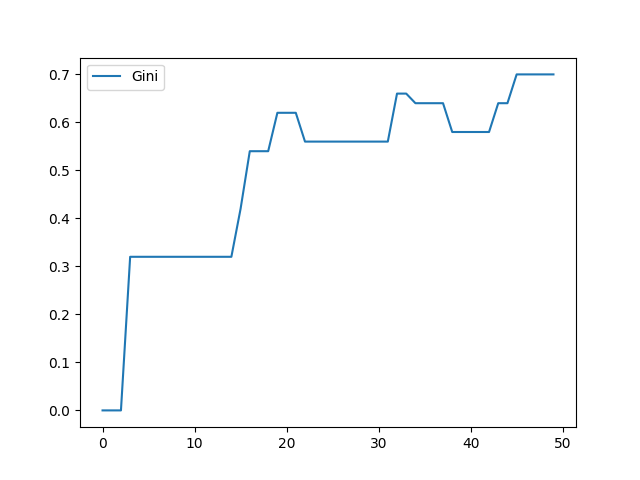

In [10]:
first_app = pn.Column(n_steps, n_agents, width,height,interactive)

first_app